## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## And so on and so forth...

In [4]:

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
#cv2.imwrite('./output_images/undistorted_'+fname.split('/')[-1],dst)

True

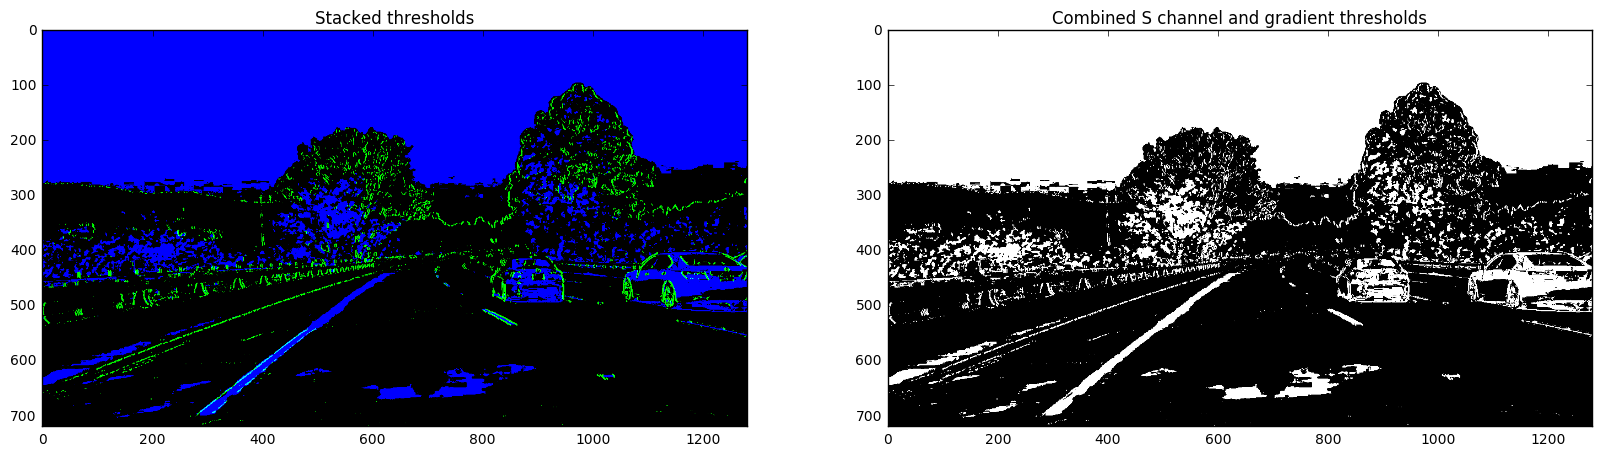

In [18]:
def dist_Corr(img,objpoints,imgpoints):
    grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,grey.shape[::-1],None,None)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist

#distortion correction example
img_path = 'test_images/test4.jpg'
img = cv2.imread(img_path)

undist_img = dist_Corr(img,objpoints,imgpoints)
#cv2.imwrite('./output_images/undistorted_'+img_path.split('/')[-1],undist_img)


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    grey = np.copy(img)
    if orient=='x':
        sobel = cv2.Sobel(grey,cv2.CV_64F,1,0,ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(grey,cv2.CV_64F,0,1,ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel) 
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Threshold gradient
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return sbinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(20, 100)):
    
    gray = np.copy(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = np.copy(img)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output



def combine_grad(img, s_thresh=(100, 255)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsl = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsl[:,:,1]
    s_channel = hsl[:,:,2]
    ksize = 3
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    gradx = abs_sobel_thresh(l_channel, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    
    mag_binary = mag_thresh(l_channel, sobel_kernel=ksize, mag_thresh=(50, 255))
    dir_binary = dir_threshold(l_channel, sobel_kernel=ksize, thresh=(0.7, 1.3))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(combined), combined, s_binary))
    thres_binary = np.zeros_like(combined)
    
    thres_binary[(s_binary == 1) | (combined == 1)] = 1
    
    return color_binary,thres_binary


color_binary,thres_binary = combine_grad(undist_img)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary,cmap='gray')

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(thres_binary,cmap='gray')

#cv2.imwrite('./output_images/binary_'+img_path.split('/')[-1],thres_binary*255)

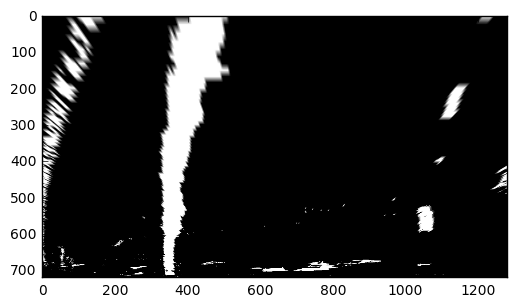

In [19]:
def perspective_trans(img):
    src = np.float32(
        [[200, 720],
        [1100, 720],
        [595, 450],
        [685, 450]])
    dst = np.float32(
        [[300, 720],
        [980, 720],
        [300, 0],
        [980, 0]])
    
    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, m, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped,m_inv

warped,m_inv = perspective_trans(thres_binary)

#cv2.imwrite('./output_images/warped_'+img_path.split('/')[-1],warped*255)

plt.imshow(warped, cmap='gray', vmin=0, vmax=1)
plt.show()

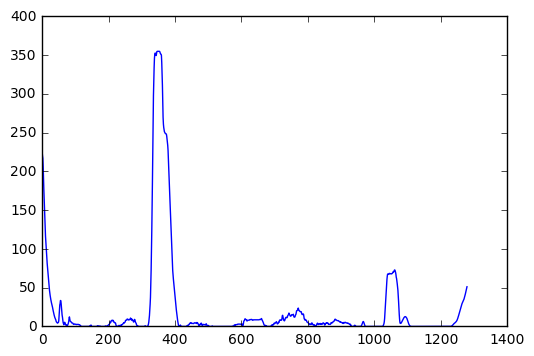

In [20]:
histogram = np.sum(warped[warped.shape[0]/2:,:], axis=0)

plt.plot(histogram)
#plt.savefig('output_images/lane_histogram.png')

(720, 0)

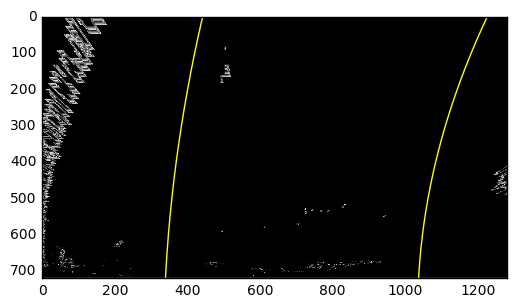

In [21]:
def lanes_in_binary1(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit,right_fit,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,out_img

left_fit,right_fit,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,out_img = lanes_in_binary1(warped)

# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

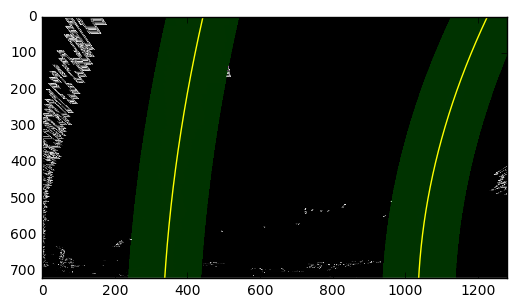

In [35]:
def lanes_in_binary2(binary_warped,left_fit,right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,left_fit,right_fit

result,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,left_fit,right_fit = lanes_in_binary2(warped,left_fit,right_fit)

plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
#plt.savefig("output_images/lanes_"+img_path.split('/')[-1])

In [23]:
def rad_curvature(binary_warped,nonzerox,nonzeroy,left_lane_inds,right_lane_inds):
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad,right_curverad

left_curverad,right_curverad = rad_curvature(warped,nonzerox,nonzeroy,left_lane_inds,right_lane_inds)

In [24]:
def vehicle_offset(undist, left_fit, right_fit):

    # Calculate vehicle center offset in pixels
    bottom_y = undist.shape[0] - 1
    
    bottom_x_left = left_fit[0]*(bottom_y**2) + left_fit[1]*bottom_y + left_fit[2]
    
    bottom_x_right = right_fit[0]*(bottom_y**2) + right_fit[1]*bottom_y + right_fit[2]
    
    offset = undist.shape[1]/2 - (bottom_x_left + bottom_x_right)/2

    # Convert pixel to meters
    xm_per_pix = 3.7/700 
    # meters per pixel in x dimension
    offset *= xm_per_pix
    return offset
offset = vehicle_offset(undist_img, left_fit, right_fit)

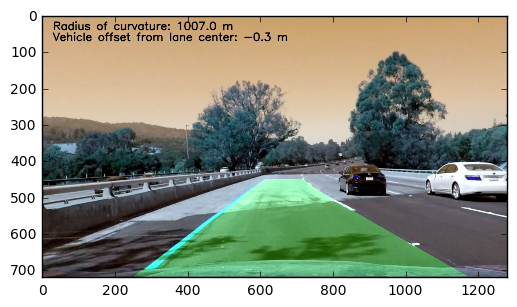

In [25]:
def resulted_image(warped,undist,Minv,left_curverad,right_curverad,offset):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    avg_curve = (left_curverad + right_curverad)/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.1f m' % offset
    result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    return result

result = resulted_image(warped,undist_img,m_inv,left_curverad,right_curverad,offset)
plt.imshow(result)
#cv2.imwrite('./output_images/result_'+fname.split('/')[-1],result)

In [39]:
global left_fit
global right_fit
def process_image(image):
    right_fit = None
    left_fit = None
    undist = dist_Corr(image,objpoints,imgpoints)
    color_binary,thres_binary = combine_grad(undist)
    warped,m_inv = perspective_trans(thres_binary)
    
    if left_fit is None and right_fit is None:
        left_fit,right_fit,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,out_img = lanes_in_binary1(warped)
    
    result,left_fitx,right_fitx,left_lane_inds,right_lane_inds,nonzerox,nonzeroy,left_fit,right_fit = lanes_in_binary2(warped,left_fit,right_fit)
    
    left_curverad,right_curverad = rad_curvature(warped,nonzerox,nonzeroy,left_lane_inds,right_lane_inds)
    offset = vehicle_offset(undist_img, left_fit, right_fit)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, 719, num=720)
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    avg_curve = (left_curverad + right_curverad)/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.1f m' % offset
    result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    return result

In [40]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

lane_lines_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_lines_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time lane_lines_clip.write_videofile(lane_lines_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [18:04<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 21min 6s, sys: 18.2 s, total: 21min 24s
Wall time: 18min 5s
